In [1]:
import os
import tensorflow as tf
import glob
import numpy as np
import sys
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
from sklearn.metrics import roc_curve, auc

from config import cfg
from data_generator import DataGenerator
from centernet3D import Mediastinal_3dcenternet
from classifier import Classifier, ClassifierTorch

In [2]:
from pytorch_model.resnet_3D import focal_loss
from utils import froc

In [3]:
with open(cfg.cross_validation, 'r') as f:
    cv = json.load(f)

In [4]:
datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT2,
                                  annotation_file=cfg.test_anno_file, results_file=cfg.test_results_file2)
test_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT,
                                  annotation_file=cfg.test_anno_file, results_file=cfg.test_results_file)

loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


In [5]:
model_dir = os.path.join(cfg.CHECKPOINTS_ROOT, 'resnet18_cls2_2_torch_spacing1')
model = ClassifierTorch(cfg.INPUT_SHAPE, model_depth=18, senet=False, is_training=True, num_classes=2, 
                        model_dir=model_dir, config=cfg, fold='fold0', num_classes2=2)

In [6]:
train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
                                  annotation_file=cfg.train_anno_file, results_file=cfg.train_results_file, 
                                    label_file=cfg.label_file, cross_validation=cv['fold0'])

loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 188


In [7]:
train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
                                  annotation_file=cfg.train_anno_file, results_file='results/fold0.json', 
                                    label_file=cfg.label_file, cross_validation=cv['fold0'])

loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 188


In [8]:
model.load_weights('./checkpoints/resnet18_cls2_2_torch_spacing1/fold0/resnet18_epoch61_0.91_0.76.pth')

In [7]:
checkpoint_file = model.find_last()
if not os.path.exists(checkpoint_file):
    print('no pretrained weight file found...')
else:
    print('loading pretrained from ', checkpoint_file)
    model.load_weights(checkpoint_file, by_name=False)

loading pretrained from  ./checkpoints/resnet18_cls3_torch_spacing1/fold0/resnet18_epoch77_0.72_0.95.pth


In [13]:
labels = torch.empty(2, dtype=torch.long).random_(3)
a = torch.randn(2, 3)
a.gather(1, labels.view(-1, 1))

tensor([[-1.6527],
        [ 0.4488]])

In [14]:
print(a, labels)

tensor([[ 0.5839, -1.6527, -0.3251],
        [ 0.4488,  0.2833, -0.5959]]) tensor([1, 0])


In [19]:
w1 = torch.zeros_like(a)
w2 = torch.ones_like(a)
torch.where(a > 0, w1, w2)

tensor([[0., 1., 1.],
        [0., 0., 1.]])

In [33]:
a = np.array([-1, -2, 3, 2])

In [30]:
def lo(w):
    w[w > -1] = 1

In [34]:
lo(a)
print(a)

[-1 -2  1  1]


In [11]:
test_res = train_datagenerator.detect_results

In [12]:
name = list(test_res.keys())[14]

In [15]:
def test(datagenerator):
    batch_size = 16
    correct = 0
    cnt = 0
    TPs = 0.0
    num_postive = 0.0
    num_test = len(datagenerator.train_list)
    res = []
    y_true = []
    names = datagenerator.train_list.copy()
    # num_test = 2
    model.model.eval()
    with torch.no_grad():
        for name in tqdm(datagenerator.train_list):
            ims_all, labels_all = datagenerator.get_all_bbox(name, channel_first=True, size=(64, 64, 64))
            y_true.append(labels_all)
            # print(ims.shape)
            preds = []
            for i in range(0, ims_all.shape[0], batch_size):
                ims = torch.tensor(ims_all[i:i+batch_size], dtype=torch.float32).cuda()
                labels = torch.tensor(labels_all[i:i+batch_size], dtype=torch.long).cuda()
                pred = model.model(ims)
                print(pred)
                preds.append(pred.detach().cpu())
                # print(cnt_preds.shape, sze_preds.shape)
    #             loss = criterion(pred, labels)
                pred = torch.argmax(pred, dim=1).detach()
                correct += torch.eq(pred, labels).sum().item()
                cnt += labels.shape[0]
                stat = labels > 0
                TP = torch.eq(pred[stat], labels[stat]).sum().item()
                N = stat.sum().item()
                TPs += TP
                num_postive += N
            res.append(torch.cat(preds, 0))
    #         names.append()
    #             test_loss.append(loss.cpu().item())
        # print(cnt_loss, sze_loss)

    test_acc = correct / cnt
    recall = TPs / num_postive
    return y_true, res, test_acc, recall

In [4]:
def test2(datagenerator, dump=True):
    batch_size = 16
    correct = 0
    cnt = 0
    TPs = 0.0
    num_postive = 0.0
    num_test = len(datagenerator.train_list)
    res_dict = {}
    res = []
    y_true = []
    names = datagenerator.train_list.copy()
    # num_test = 2
    model.model.eval()
    with torch.no_grad():
        for name in tqdm(datagenerator.train_list):
            temp = {}
            ims_all, labels_all = datagenerator.get_all_bbox(name, channel_first=True, size=(64, 64, 64))
            y_true.append(labels_all)
            # print(ims.shape)
            preds1, preds2 = [], []
            for i in range(0, ims_all.shape[0], batch_size):
                ims = torch.tensor(ims_all[i:i+batch_size], dtype=torch.float32).cuda()
                labels = torch.tensor(labels_all[i:i+batch_size], dtype=torch.long).cuda()
                pred1, pred2 = model.model(ims)
                pred1 = torch.softmax(pred1, dim=1)
                pred2 = torch.softmax(pred2, dim=1)
                preds1.append(pred1.detach().cpu())
                preds2.append(pred2.detach().cpu())
            res.append((torch.cat(preds1, 0), torch.cat(preds2, 0)))
            if dump:
                temp['y_true'] = np.array(labels_all, dtype=np.int32).tolist()
                temp['y_pred1'] = res[-1][0].numpy().tolist()
                temp['y_pred2'] = res[-1][1].numpy().tolist()
                res_dict[name] = temp
    if dump:
        return y_true, res, res_dict
    else:
        return y_true, res

In [ ]:
def test_cls(datagenerator, dump=True):
    batch_size = 16
    correct = 0
    cnt = 0
    TPs = 0.0
    num_postive = 0.0
    num_test = len(datagenerator.train_list)
    res_dict = {}
    res = []
    y_true = []
    names = datagenerator.train_list.copy()
    # num_test = 2
    model.model.eval()
    with torch.no_grad():
        for name in tqdm(datagenerator.train_list):
            temp = {}
            ims_all, labels_all = datagenerator.get_all_bbox(name, channel_first=True, size=(64, 64, 64))
            y_true.append(labels_all)
            # print(ims.shape)
#             preds1, preds2 = [], []
            preds = []
            for i in range(0, ims_all.shape[0], batch_size):
                ims = torch.tensor(ims_all[i:i+batch_size], dtype=torch.float32).cuda()
                labels = torch.tensor(labels_all[i:i+batch_size], dtype=torch.long).cuda()
                _, pred = model.model(ims)
                pred = torch.softmax(pred, dim=1)
                preds.append(pred.detach().cpu())
            res.append(torch.cat(preds1, 0))
            if dump:
                temp['y_true'] = np.array(labels_all, dtype=np.int32).tolist()
                temp['y_pred1'] = res[-1][0].numpy().tolist()
                temp['y_pred2'] = res[-1][1].numpy().tolist()
                res_dict[name] = temp
    if dump:
        return y_true, res, res_dict
    else:
        return y_true, res

In [10]:
y_true1, res1, res_dict = test2(train_datagenerator, dump=True)

100%|██████████| 188/188 [14:42<00:00,  5.52s/it]


In [23]:
_, _, res_dict2 = test2(datagenerator, dump=True)
_, _, res_dict3 = test2(test_datagenerator, dump=True)
res_dict2.update(res_dict3)

 45%|████▍     | 84/187 [11:19<13:36,  7.92s/it]

KeyboardInterrupt: 

In [32]:
_

[(tensor([[1.3158e-07, 1.0000e+00],
          [7.2606e-06, 9.9999e-01],
          [9.9973e-01, 2.6587e-04],
          [9.9926e-01, 7.4461e-04],
          [9.9961e-01, 3.8833e-04],
          [9.9052e-01, 9.4799e-03],
          [9.9234e-01, 7.6567e-03],
          [9.9161e-01, 8.3871e-03],
          [7.4982e-01, 2.5018e-01],
          [9.6054e-01, 3.9461e-02],
          [9.9836e-01, 1.6422e-03],
          [9.9897e-01, 1.0264e-03],
          [9.9975e-01, 2.4797e-04],
          [9.9997e-01, 2.8556e-05],
          [9.9994e-01, 6.1977e-05],
          [9.9971e-01, 2.9182e-04],
          [9.9615e-01, 3.8529e-03],
          [9.9729e-01, 2.7109e-03],
          [9.9953e-01, 4.7147e-04],
          [8.4883e-01, 1.5117e-01],
          [9.9872e-01, 1.2839e-03],
          [9.9799e-01, 2.0130e-03],
          [9.9972e-01, 2.7644e-04],
          [9.9999e-01, 1.4090e-05],
          [9.3458e-01, 6.5416e-02],
          [6.4498e-01, 3.5502e-01],
          [9.9873e-01, 1.2733e-03],
          [9.9543e-01, 4.569

In [20]:
for key in res_dict.keys():
#     res_dict[key]['y_true'] = np.array(res_dict[key]['y_true'], dtype=np.int32).tolist()
    res_dict[key]['y_pred1'] = torch.softmax(torch.tensor(res_dict[key]['y_pred1']), 1).numpy().tolist()
    res_dict[key]['y_pred2'] = torch.softmax(torch.tensor(res_dict[key]['y_pred2']), 1).numpy().tolist()

In [16]:
a = torch.rand((10, 2))
torch.softmax(a, dim=1)

tensor([[0.5426, 0.4574],
        [0.4918, 0.5082],
        [0.3434, 0.6566],
        [0.5700, 0.4300],
        [0.5329, 0.4671],
        [0.4425, 0.5575],
        [0.5181, 0.4819],
        [0.5731, 0.4269],
        [0.5027, 0.4973],
        [0.5023, 0.4977]])

In [22]:
with open('./results/fold0_fp.json', 'w') as f:
    json.dump(res_dict, f)

In [92]:
y_true, res, res_dict = test2(test_datagenerator, dump=True)

100%|██████████| 13/13 [01:53<00:00,  9.04s/it]


In [23]:
res_ = [e.numpy().tolist() for e in res]

In [26]:
res1_ = [e.numpy().tolist() for e in res1]

In [44]:
d = {
    "train_y": y,
    "train_res": res_,
    "test_y": y1,
    "test_res": res1_
}

188

In [40]:
y = [list(map(float, y)) for y in y_true]

In [43]:
y1 = [list(map(float, y)) for y in y_true1]

In [45]:
with open("results/cls3_res.json", 'w') as f:
    json.dump(d, f)

In [39]:
model_dir = os.path.join(cfg.CHECKPOINTS_ROOT, 'resnet18_cls2_2_torch_spacing1')
model = ClassifierTorch(cfg.INPUT_SHAPE, model_depth=18, senet=False, is_training=True, num_classes=2, 
                        model_dir=model_dir, config=cfg, fold='fold0', num_classes2=2)
model.load_weights('./checkpoints/resnet18_cls2_2_torch_spacing1/fold0/resnet18_epoch61_0.91_0.76.pth')

train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
                                  annotation_file=cfg.train_anno_file, results_file='results/fold0.json', 
                                    label_file=cfg.label_file, cross_validation=cv['fold0'])
test_datagenerator1 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT2,
                                  annotation_file=cfg.test_anno_file, results_file='./results/fold0_test.json')
test_datagenerator2 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT,
                                  annotation_file=cfg.test_anno_file, results_file='./results/fold0_test.json')
_, _, res_dict = test2(train_datagenerator, dump=True)
_, _, res_dict1 = test2(test_datagenerator1, dump=True)
_, _, res_dict2 = test2(test_datagenerator2, dump=True)
res_dict1.update(res_dict2)
with open('./results/fold0_fp.json', 'w') as f:
    json.dump(res_dict, f)
with open('./results/fold0_fp_test.json', 'w') as f:
    json.dump(res_dict1, f)

train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
                                  annotation_file=cfg.train_anno_file, results_file='results/fold0_FPN.json', 
                                    label_file=cfg.label_file, cross_validation=cv['fold0'])
test_datagenerator1 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT2,
                                  annotation_file=cfg.test_anno_file, results_file='./results/fold0_FPN_test.json')
test_datagenerator2 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT,
                                  annotation_file=cfg.test_anno_file, results_file='./results/fold0_FPN_test.json')
_, _, res_dict = test2(train_datagenerator)
_, _, res_dict1 = test2(test_datagenerator1)
_, _, res_dict2 = test2(test_datagenerator2)
res_dict1.update(res_dict2)
with open('./results/fold0_FPN_fp.json', 'w') as f:
    json.dump(res_dict, f)
with open('./results/fold0_FPN_fp_test.json', 'w') as f:
    json.dump(res_dict1, f)

loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 188
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13
loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 188
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json







  0%|          | 0/2 [00:00<?, ?it/s]

load annotation done
found test images: 13







 50%|█████     | 1/2 [00:09<00:09,  9.19s/it]




100%|██████████| 2/2 [00:17<00:00,  8.97s/it]

In [5]:
for fold_id in ["fold0", "fold1", "fold2", "fold3", "fold4"]:
    model_dir = os.path.join(cfg.CHECKPOINTS_ROOT, 'resnet18_cls2_2_torch_spacing1')
    model = ClassifierTorch(cfg.INPUT_SHAPE, model_depth=18, senet=False, is_training=True, num_classes=2, 
                            model_dir=model_dir, config=cfg, fold=fold_id, num_classes2=2)
    if fold_id == "fold0":
        model.load_weights('./checkpoints/resnet18_cls2_2_torch_spacing1/fold0/resnet18_epoch61_0.91_0.76.pth')
    elif fold_id == "fold1":
        model.load_weights('./checkpoints/resnet18_cls2_2_torch_spacing1/fold1/resnet18_epoch80_0.94_0.81.pth')
    elif fold_id == "fold2":
        model.load_weights('./checkpoints/resnet18_cls2_2_torch_spacing1/fold2/resnet18_epoch60_0.94_0.85.pth')
    elif fold_id == "fold3":
        model.load_weights('./checkpoints/resnet18_cls2_2_torch_spacing1/fold3/resnet18_epoch80_0.95_0.83.pth')
    elif fold_id == "fold4":
        model.load_weights('./checkpoints/resnet18_cls2_2_torch_spacing1/fold4/resnet18_epoch66_0.94_0.86.pth')

    train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
                                      annotation_file=cfg.train_anno_file, results_file='results/%s.json' % fold_id, 
                                        label_file=cfg.label_file, cross_validation=cv[fold_id])
    test_datagenerator1 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT2,
                                annotation_file=cfg.test_anno_file, results_file='./results/%s_test.json' % fold_id)
    test_datagenerator2 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT,
                                annotation_file=cfg.test_anno_file, results_file='./results/%s_test.json' % fold_id)
    _, _, res_dict = test2(train_datagenerator, dump=True)
    _, _, res_dict1 = test2(test_datagenerator1, dump=True)
    _, _, res_dict2 = test2(test_datagenerator2, dump=True)
    res_dict1.update(res_dict2)
    with open('./results/%s_fp.json' % fold_id, 'w') as f:
        json.dump(res_dict, f)
    with open('./results/%s_fp_test.json' % fold_id, 'w') as f:
        json.dump(res_dict1, f)

    train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
                                      annotation_file=cfg.train_anno_file, results_file='results/%s_FPN.json' % fold_id, 
                                        label_file=cfg.label_file, cross_validation=cv[fold_id])
    test_datagenerator1 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT2,
                                annotation_file=cfg.test_anno_file, results_file='./results/%s_FPN_test.json' % fold_id)
    test_datagenerator2 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT,
                                annotation_file=cfg.test_anno_file, results_file='./results/%s_FPN_test.json' % fold_id)
    _, _, res_dict = test2(train_datagenerator)
    _, _, res_dict1 = test2(test_datagenerator1)
    _, _, res_dict2 = test2(test_datagenerator2)
    res_dict1.update(res_dict2)
    with open('./results/%s_FPN_fp.json' % fold_id, 'w') as f:
        json.dump(res_dict, f)
    with open('./results/%s_FPN_fp_test.json' % fold_id, 'w') as f:
        json.dump(res_dict1, f)

loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 188
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json


  0%|          | 0/188 [00:00<?, ?it/s]

load annotation done
found test images: 13


100%|██████████| 13/13 [02:00<00:00,  8.91s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/188 [00:00<?, ?it/s]

load annotation done
found test images: 188
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


100%|██████████| 13/13 [02:42<00:00, 11.66s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/187 [00:00<?, ?it/s]

load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


100%|██████████| 13/13 [02:01<00:00, 10.13s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json


  0%|          | 0/187 [00:00<?, ?it/s]

load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


100%|██████████| 13/13 [02:40<00:00, 12.38s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/187 [00:00<?, ?it/s]

load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


100%|██████████| 13/13 [02:23<00:00, 11.44s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json


  0%|          | 0/187 [00:00<?, ?it/s]

load annotation done
found test images: 13


100%|██████████| 13/13 [03:08<00:00, 13.92s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187
loading annotations from 

  0%|          | 0/187 [00:00<?, ?it/s]

 /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


100%|██████████| 13/13 [01:54<00:00,  7.79s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json


  0%|          | 0/187 [00:00<?, ?it/s]

load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


100%|██████████| 13/13 [03:11<00:00, 14.41s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json


  0%|          | 0/187 [00:00<?, ?it/s]

load annotation done
found test images: 13


100%|██████████| 13/13 [01:48<00:00,  8.13s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json


  0%|          | 0/187 [00:00<?, ?it/s]

load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


100%|██████████| 13/13 [02:25<00:00, 11.86s/it]


In [6]:
for fold_id in ["fold0", "fold1", "fold2", "fold3", "fold4"]:
    model_dir = os.path.join(cfg.CHECKPOINTS_ROOT, 'resnet18se_cls2_2_torch_spacing1')
    model = ClassifierTorch(cfg.INPUT_SHAPE, model_depth=18, senet=True, is_training=True, num_classes=2, 
                            model_dir=model_dir, config=cfg, fold=fold_id, num_classes2=2)
    if fold_id == "fold0":
        model.load_weights('./checkpoints/resnet18se_cls2_2_torch_spacing1/fold0/seresnet18_epoch79_0.92_0.81.pth')
    elif fold_id == "fold1":
        model.load_weights('./checkpoints/resnet18se_cls2_2_torch_spacing1/fold1/seresnet18_epoch53_0.90_0.83.pth')
    elif fold_id == "fold2":
        continue
        model.load_weights('./checkpoints/resnet18se_cls2_2_torch_spacing1/fold2/seresnet18_epoch60_0.94_0.85.pth')
    elif fold_id == "fold3":
        model.load_weights('./checkpoints/resnet18se_cls2_2_torch_spacing1/fold3/seresnet18_epoch72_0.92_0.84.pth')
    elif fold_id == "fold4":
        model.load_weights('./checkpoints/resnet18se_cls2_2_torch_spacing1/fold4/seresnet18_epoch80_0.91_0.88.pth')

#     train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
#                                       annotation_file=cfg.train_anno_file, results_file='results/%s.json' % fold_id, 
#                                         label_file=cfg.label_file, cross_validation=cv[fold_id])
#     test_datagenerator1 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT2,
#                                 annotation_file=cfg.test_anno_file, results_file='./results/%s_test.json' % fold_id)
#     test_datagenerator2 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT,
#                                 annotation_file=cfg.test_anno_file, results_file='./results/%s_test.json' % fold_id)
#     _, _, res_dict = test2(train_datagenerator, dump=True)
#     _, _, res_dict1 = test2(test_datagenerator1, dump=True)
#     _, _, res_dict2 = test2(test_datagenerator2, dump=True)
#     res_dict1.update(res_dict2)
#     with open('./results/%s_fp.json' % fold_id, 'w') as f:
#         json.dump(res_dict, f)
#     with open('./results/%s_fp_test.json' % fold_id, 'w') as f:
#         json.dump(res_dict1, f)

    train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
                                      annotation_file=cfg.train_anno_file, results_file='results/%s_FPN.json' % fold_id, 
                                        label_file=cfg.label_file, cross_validation=cv[fold_id])
    test_datagenerator1 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT2,
                                annotation_file=cfg.test_anno_file, results_file='./results/%s_FPN_test.json' % fold_id)
    test_datagenerator2 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT,
                                annotation_file=cfg.test_anno_file, results_file='./results/%s_FPN_test.json' % fold_id)
    _, _, res_dict = test2(train_datagenerator)
    _, _, res_dict1 = test2(test_datagenerator1)
    _, _, res_dict2 = test2(test_datagenerator2)
    res_dict1.update(res_dict2)
    with open('./results/%s_FPN_fp_se.json' % fold_id, 'w') as f:
        json.dump(res_dict, f)
    with open('./results/%s_FPN_fp_se_test.json' % fold_id, 'w') as f:
        json.dump(res_dict1, f)

loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 188
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json


  0%|          | 0/188 [00:00<?, ?it/s]

load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


100%|██████████| 13/13 [02:50<00:00, 14.43s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json


  0%|          | 0/187 [00:00<?, ?it/s]

load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


100%|██████████| 13/13 [02:48<00:00, 12.13s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json


  0%|          | 0/187 [00:00<?, ?it/s]

load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


100%|██████████| 13/13 [03:22<00:00, 15.44s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json


  0%|          | 0/187 [00:00<?, ?it/s]

load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


100%|██████████| 13/13 [02:32<00:00, 11.82s/it]


In [ ]:
for fold_id in ["fold0", "fold1", "fold2", "fold3", "fold4"]:
    model_dir = os.path.join(cfg.CHECKPOINTS_ROOT, 'resnet18se_cls2_2_torch_spacing1')
    model = ClassifierTorch(cfg.INPUT_SHAPE, model_depth=18, senet=True, is_training=True, num_classes=2, 
                            model_dir=model_dir, config=cfg, fold=fold_id, num_classes2=2)
    if fold_id == "fold0":
        model.load_weights('./checkpoints/resnet18se_cls2_2_torch_spacing1/fold0/seresnet18_epoch79_0.92_0.81.pth')
    elif fold_id == "fold1":
        model.load_weights('./checkpoints/resnet18se_cls2_2_torch_spacing1/fold1/seresnet18_epoch53_0.90_0.83.pth')
    elif fold_id == "fold2":
        continue
        model.load_weights('./checkpoints/resnet18se_cls2_2_torch_spacing1/fold2/seresnet18_epoch60_0.94_0.85.pth')
    elif fold_id == "fold3":
        model.load_weights('./checkpoints/resnet18se_cls2_2_torch_spacing1/fold3/seresnet18_epoch72_0.92_0.84.pth')
    elif fold_id == "fold4":
        model.load_weights('./checkpoints/resnet18se_cls2_2_torch_spacing1/fold4/seresnet18_epoch80_0.91_0.88.pth')

    train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
                                      annotation_file=cfg.train_anno_file, results_file='results/%s_FPN_fpr.json' % fold_id, 
                                        label_file=cfg.label_file, cross_validation=cv[fold_id])
    _, _, res_dict = test2(train_datagenerator)
    _, _, res_dict1 = test2(test_datagenerator1)
    _, _, res_dict2 = test2(test_datagenerator2)
    res_dict1.update(res_dict2)
    with open('./results/%s_FPN_fp_se.json' % fold_id, 'w') as f:
        json.dump(res_dict, f)
    with open('./results/%s_FPN_fp_se_test.json' % fold_id, 'w') as f:
        json.dump(res_dict1, f)

In [4]:
def get_sensitivity(fps, tps):
    res = []
    for n in [0.125, 0.25, 0.5, 1, 2, 4, 8]:
        for i in range(len(fps)):
            if fps[i] >= n and fps[i+1] <= n:
                temp = (tps[i] - tps[i+1]) / (fps[i] - fps[i+1]) * (n - fps[i+1]) + tps[i+1]
                res.append(temp)
                print(n, "%.4f"%temp)
                break
            if i == len(fps)-1:
                res.append(temp)
                print(n, "%.4f"%temp)
    avg = np.mean(res)
    res.append(avg)
    print("avg: ", "%.4f"%np.mean(res))
    return res

In [34]:
def get_sen(fps, tps):
    res = []
    for n in np.arange(0, 8, 0.05):
        for i in range(len(fps)):
            if fps[i] >= n and fps[i+1] <= n:
                temp = (tps[i] - tps[i+1]) / (fps[i] - fps[i+1]) * (n - fps[i+1]) + tps[i+1]
                res.append(temp)
                break
            if i == len(fps)-1:
                res.append(temp)
    return res

In [74]:
def get_FPR_Result(detect, cls):
    cls_result = {}
    for key in detect.keys():
        now = {}
        now.update(detect[key])
        final_score = np.array(cls[key]["y_pred1"])[:, 1] #+ np.array(now['score'])
#         print(sorted(final_score)[-3:])
        idx = final_score>=0.3
        idx[:1] = True
        
        now['bbox_pred'] = np.array(detect[key]['bbox_pred'])[idx].tolist()
        now['score'] = np.array(detect[key]['score'])[idx].tolist()
        now['cls_pred'] = np.array(cls[key]["y_pred2"])[idx].tolist()
        now['cls_true'] = np.array(cls[key]['y_true'])[idx].tolist()
        cls_result[key] = now
    return cls_result

In [87]:
def get_cls_result(cls):
    y_pred = []
    y_true = []
    for name in cls.keys():
        y_pred.append(np.array(cls[name]['cls_pred']))
        y_true.append(np.array(cls[name]['cls_true']))
    y_pred = np.vstack(y_pred)
    y_true = np.hstack(y_true)
    idx = np.where(y_true > 0)
    y_pred = y_pred[idx]
    y_true = y_true[idx] - 1
    y_pred_ = np.argmax(y_pred, axis=1)
    acc = np.sum(y_pred_ == y_true) / len(y_pred_)
    return y_pred, y_true, acc

In [113]:
detection_results = {}
detection_results_FPN = {}

cls_results = {}
cls_results_FPN = {}
cls_results_FPN_SE = {}
for fold in ["fold0", "fold1", "fold2", "fold3", "fold4"]:
    print(fold)
    cls = []
    with open('./results/%s.json' % fold) as f:
        detection_results.update(json.load(f))
    with open('./results/%s_fp.json' % fold) as f:
        cls_results.update(json.load(f))
    
    with open('./results/%s_FPN.json' % fold) as f:
        detection_results_FPN.update(json.load(f))
    with open('./results/%s_FPN_fp.json' % fold) as f:
        cls_results_FPN.update(json.load(f))

    with open('./results/%s_FPN_fp_se.json' % fold) as f:
        cls_results_FPN_SE.update(json.load(f))


fold0
fold1
fold2
fold3
fold4


In [114]:
cls_results = get_FPR_Result(detection_results, cls_results)
cls_results_FPN = get_FPR_Result(detection_results_FPN, cls_results_FPN)
cls_results_FPN_SE = get_FPR_Result(detection_results_FPN, cls_results_FPN_SE)

In [115]:
def get_diffsize_result(lesion_size, detect_results):
    results = [{}, {}, {}, {}, {}]
    for name in detect_results.keys():
        s = np.mean(lesion_size[name][0])
        if s < 30:
            results[0][name] = detect_results[name]
        elif s >= 30 and s < 50:
            results[1][name] = detect_results[name]
        elif s >= 50 and s < 70:
            results[2][name] = detect_results[name]
        elif s >= 70 and s < 100:
            results[3][name] = detect_results[name]
        elif s >= 100:
            results[4][name] = detect_results[name]
    for i in range(5):
        fpr, tpr, _ = froc(results[i], method="iobb", iou_threshold=0.3, nms=False)
        res = get_sensitivity(fpr, tpr)

In [120]:
get_diffsize_result(lesion, cls_results_FPN_SE)

 96%|█████████▌| 284/297 [00:00<00:00, 1353.89it/s]

0.125 0.8679
0.25 0.9121
0.5 0.9404
1 0.9404
2 0.9404
4 0.9404
8 0.9404
avg:  0.9260


  0%|          | 0/52 [00:00<?, ?it/s]

0.125 0.9158
0.25 0.9561
0.5 0.9663
1 0.9663
2 0.9663
4 0.9663
8 0.9663
avg:  0.9577
0.125 0.8874
0.25 0.9298
0.5 0.9528
1 0.9648
2 0.9648
4 0.9648
8 0.9648
avg:  0.9470
0.125 0.8028
0.25 0.8884
0.5 0.9422
1 0.9778
2 0.9778
4 0.9778
8 0.9778
avg:  0.9349


100%|██████████| 52/52 [00:00<00:00, 1371.88it/s]

0.125 0.4952
0.25 0.6538
0.5 0.9135
1 0.9734
2 0.9808
4 0.9808
8 0.9808
avg:  0.8540


  0%|          | 0/188 [00:00<?, ?it/s]

fold0


100%|██████████| 188/188 [00:00<00:00, 1422.39it/s]


detection:
0.125 0.7487
0.25 0.8473
0.5 0.9066
1 0.9300
2 0.9362
4 0.9415
8 0.9505
avg:  0.8944
FPR:
0.125 0.8320
0.25 0.9096
0.5 0.9248
1 0.9456
2 0.9494
4 0.9494
8 0.9494
avg:  0.9229
0.7526315789473684 0.7876580412708811
fold1


100%|██████████| 187/187 [00:00<00:00, 1527.14it/s]


detection:
0.125 0.7203
0.25 0.8320
0.5 0.8875
1 0.9158
2 0.9425
4 0.9478
8 0.9525
avg:  0.8855
FPR:
0.125 0.7660
0.25 0.8867
0.5 0.9321
1 0.9434
2 0.9686
4 0.9748
8 0.9748
avg:  0.9209
0.7992766726943942 0.8407028026746337
fold2


100%|██████████| 187/187 [00:00<00:00, 1403.27it/s]


detection:
0.125 0.7856
0.25 0.8242
0.5 0.8815
1 0.9206
2 0.9414
4 0.9509
8 0.9595
avg:  0.8948
FPR:
0.125 0.7951
0.25 0.8476
0.5 0.9454
1 0.9572
2 0.9572
4 0.9572
8 0.9572
avg:  0.9167
0.8230912476722533 0.8812360624402676
fold3


100%|██████████| 187/187 [00:00<00:00, 1523.39it/s]


detection:
0.125 0.8095
0.25 0.8669
0.5 0.8984
1 0.9265
2 0.9446
4 0.9515
8 0.9594
avg:  0.9081
FPR:
0.125 0.8681
0.25 0.8984
0.5 0.9494
1 0.9596
2 0.9642
4 0.9642
8 0.9642
avg:  0.9383
0.8006872852233677 0.8703853074393497
fold4


100%|██████████| 187/187 [00:00<00:00, 1485.39it/s]


detection:
0.125 0.8085
0.25 0.8689
0.5 0.9063
1 0.9416
2 0.9650
4 0.9756
8 0.9845
avg:  0.9215
FPR:
0.125 0.8876
0.25 0.9372
0.5 0.9734
1 0.9868
2 0.9893
4 0.9893
8 0.9893
avg:  0.9647
0.8241563055062167 0.8650275323344858


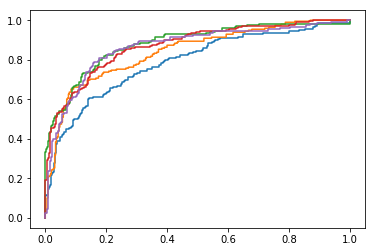

In [105]:
y_preds = []
y_trues = []
for fold in ["fold0", "fold1", "fold2", "fold3", "fold4"]:
    print(fold)
    cls = []
    with open('./results/%s_FPN.json' % fold) as f:
        detect_result1 = json.load(f)
    with open('./results/%s_FPN_fp.json' % fold) as f:
        cls_result1 = json.load(f)
    fpr_result = get_FPR_Result(detect_result1, cls_result1)
    fpr, tpr, _ = froc(detect_result1, method="iobb", iou_threshold=0.3, nms=False)
    print("detection:")
    res = get_sensitivity(fpr, tpr)
    fpr, tpr, _ = froc(fpr_result, method="iobb", iou_threshold=0.3, nms=False)
    print("FPR:")
    res = get_sensitivity(fpr, tpr)
    
    y_pred, y_true, acc = get_cls_result(fpr_result)
    y_preds.append(y_pred[:, 1])
    y_trues.append(y_true)
    tpr, fpr, th = roc_curve(y_true, y_pred[:, 1])
    AUC = auc(tpr, fpr)
    print(acc, AUC)
    plt.plot(tpr, fpr)

In [104]:
y_pred2 = np.hstack(y_preds)
y_true2 = np.hstack(y_trues)

In [106]:
y_pred1 = np.hstack(y_preds)
y_true1 = np.hstack(y_trues)

In [102]:
y_pred.shape

(553, 2)

0.8446234456738062 0.8755350822494093
0.7996434937611409 0.8243831640058055


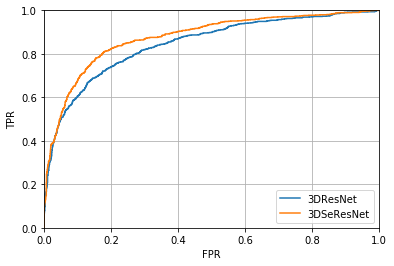

In [109]:
fpr2, tpr2, th2 = roc_curve(y_true2, y_pred2)
fpr1, tpr1, th1 = roc_curve(y_true1, y_pred1)
AUC1 = auc(fpr1, tpr1)
AUC2 = auc(fpr2, tpr2)
print(AUC1, AUC2)
print(np.mean((y_pred1 >= 0.5) == y_true1), np.mean((y_pred2 >= 0.5) == y_true2))
plt.plot(fpr1, tpr1)
plt.plot(fpr2, tpr2)
plt.legend(["3DResNet", "3DSeResNet"], loc='lower right')
plt.grid(True, which="both",ls="-") 
plt.xlim(0, 1.0)
plt.ylim(0, 1.0)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.savefig("results/cls_2methods.png")

In [52]:
sen1 = []
sen2 = []
for fold in ["fold0", "fold1", "fold2", "fold3", "fold4"]:
    print(fold)
    with open('./results/%s_FPN_test.json' % fold) as f:
        detect_result1 = json.load(f)
    with open('./results/%s_FPN_fp_test.json' % fold) as f:
        cls_result1 = json.load(f)
    fpr_result = get_FPR_Result(detect_result1, cls_result1)
    fpr, tpr, _ = froc(detect_result1, method="iobb", iou_threshold=0.3, nms=False)
#     print("detection:")
    res = get_sen(fpr, tpr)
    sen1.append(res)
    fpr, tpr, _ = froc(fpr_result, method="iobb", iou_threshold=0.3, nms=False)
#     print("FPR:")
    res = get_sen(fpr, tpr)
    sen2.append(res)

fold0


 64%|██████▍   | 129/200 [00:00<00:00, 1287.55it/s]

fold1


100%|██████████| 200/200 [00:00<00:00, 1675.48it/s]


fold2


100%|██████████| 200/200 [00:00<00:00, 1494.13it/s]


fold3


100%|██████████| 200/200 [00:00<00:00, 1657.55it/s]


fold4


100%|██████████| 200/200 [00:00<00:00, 1412.26it/s]


In [36]:
sen_FPN = np.mean(np.array(sen1), axis=0)
sen_FPN_fpr = np.mean(np.array(sen2), axis=0)

In [53]:
sen_FPN_fpr2 = np.mean(np.array(sen2), axis=0)

In [45]:
sen = np.mean(np.array(sen1), axis=0)
sen_fpr = np.mean(np.array(sen2), axis=0)

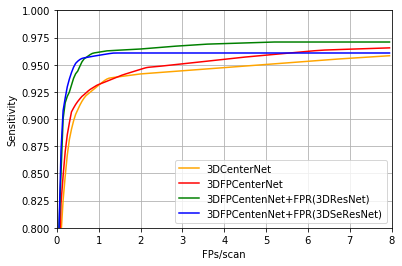

In [110]:
plt.plot(np.arange(0, 8, 0.05), sen, 'orange')
# plt.plot(np.arange(0, 8, 0.05), sen_fpr)
plt.plot(np.arange(0, 8, 0.05), sen_FPN, 'r')
plt.plot(np.arange(0, 8, 0.05), sen_FPN_fpr2, 'g')
plt.plot(np.arange(0, 8, 0.05), sen_FPN_fpr, 'b')
plt.legend(["3DCenterNet", "3DFPCenterNet", "3DFPCentenNet+FPR(3DResNet)", "3DFPCentenNet+FPR(3DSeResNet)"])
plt.grid(True, which="both",ls="-") 
plt.xlim(0, 8)
plt.ylim(0.8, 1.0)
plt.xlabel('FPs/scan')
plt.ylabel('Sensitivity')
plt.savefig("results/sen_4methods.png")

In [64]:
cls_result1["0333213"]

{'y_true': [1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'y_pred1': [[9.659562039132652e-11, 1.0],
  [0.3798195421695709, 0.6201804280281067],
  [0.9968097805976868, 0.003190178656950593],
  [0.9995636343955994, 0.0004364117921795696],
  [0.9574048519134521, 0.04259512200951576],
  [0.9995044469833374, 0.0004955633776262403],
  [0.9999278783798218, 7.212092896224931e-05],
  [0.99991

In [ ]:
with open('./results/fold1.json') as f:
    detect_result1 = json.load(f)
with open('./results/fold1_fp.json') as f:
    cls_result1 = json.load(f)

In [146]:
fpr_result = get_FPR_Result(detect_result1, cls_result1)

In [149]:
fpr, tpr, _ = froc(detect_result1, method="iobb", iou_threshold=0.3, nms=False)

100%|██████████| 187/187 [00:00<00:00, 1279.35it/s]


In [150]:
get_sensitivity(fpr, tpr)

0.125 0.8031
0.25 0.8570
0.5 0.8770
1 0.9097
2 0.9176
4 0.9243
8 0.9376
avg:  0.8895


[0.8031417112299465,
 0.856951871657754,
 0.877005347593583,
 0.9096985901798735,
 0.9175546489679108,
 0.9242525726115813,
 0.9376484198989222,
 0.8894647374485102]

In [151]:
fpr, tpr, _ = froc(fpr_result, method="iobb", iou_threshold=0.3, nms=False)

100%|██████████| 187/187 [00:00<00:00, 1718.98it/s]


In [124]:
get_sensitivity(fpr, tpr)

0.125 0.892379679144385
0.25 0.9442959001782532
0.5 0.9572192513368984
1 0.9572192513368984
2 0.9572192513368984
4 0.9572192513368984
8 0.9572192513368984
avg:  0.9461102622867328


Text(0, 0.5, 'Sensitivity')

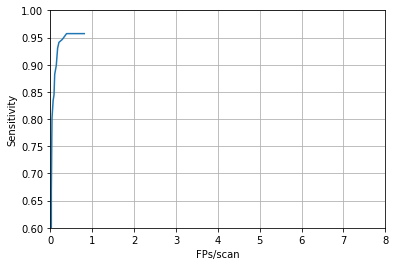

In [125]:
plt.plot(fpr,tpr)
plt.grid(True, which="both",ls="-") 
plt.xlim(0, 8)
plt.ylim(0.6, 1.0)
plt.xlabel('FPs/scan')
plt.ylabel('Sensitivity')

In [79]:
def get_metrics(y_true, y_pred):
    FPR, TPR, _ = roc_curve(y_true, y_pred)
    auc_score = auc(FPR, TPR)
    n = len(y_true)
    y_pred_cls = np.where(y_pred > 0.5, 1, 0).astype(np.int)
    TP = np.sum(y_pred[y_true == 1])
    FN = np.sum(y_true) - TP
    FP = np.sum(y_pred) - TP
    TN = n - TP - FN - FP
    acc = (TP + TN) / n
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    return acc, precision, recall, auc_score

In [80]:
def eval_cls(y_true, res):
    y = []
    for x in y_true:
        y += x    
    y = np.array(y)
#     print(y)
    fpr = torch.cat([x[0] for x in res])
    cls = torch.cat([x[1] for x in res])
    fpr = torch.softmax(fpr, dim=1).numpy()[:, 1]
    cls = torch.softmax(cls, dim=1).numpy()[:, 1]
    y1 = y.copy()
    y1[y>1] = 1
    y2 = y[y>0] - 1
    cls = cls[y>0]
    
    metric1 = get_metrics(y1, fpr)
    metric2 = get_metrics(y2, cls)
    return metric1, metric2

In [17]:
def get_FP_recall(y_true1, res1):
    y_true1_ = []
    for y in y_true1:
        y_true1_ += y
    y_true1_ = np.array(y_true1_)
    res1_ = [torch.argmax(x, dim=1) for x in res1]
    res1_ = torch.cat(res1_).numpy()
#     res1_[res1_>0] = 1
    FP = np.mean(res1_[y_true1_ > 0] > 0)
    cls2 = np.mean(res1_[y_true1_ == 2] == 2)
    cls1 = np.mean(res1_[y_true1_ == 1] == 1)
    cls = np.mean(res1_[y_true1_ > 0] == y_true1_[y_true1_ > 0])
    return FP, cls1, cls2, cls

In [85]:
eval_cls(y_true, res)

((0.9687000662061127, 0.2949597, 0.9139293569379148, 0.9858521468756173),
 (0.7349792075368156, 0.71266145, 0.5086215706758721, 0.7808970099667775))

In [112]:
with open('results/lesion_size.json', 'r') as f:
    lesion = json.load(f)

len(lesion.keys())

1136

In [66]:
fpr = torch.cat([x[0] for x in res])
cls = torch.cat([x[1] for x in res])
fpr = torch.softmax(fpr, dim=1).numpy()[:, 1]
cls = torch.softmax(cls, dim=1).numpy()[:, 1]

In [77]:
np.where(fpr > 0.5, 0, 1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [78]:
fpr

array([0.        , 0.        , 0.        , 0.00628931, 0.00628931,
       0.01886792, 0.01886792, 0.02515723, 0.02515723, 0.03773585,
       0.03773585, 0.04402516, 0.04402516, 0.05031447, 0.05031447,
       0.05660377, 0.05660377, 0.06289308, 0.06289308, 0.06918239,
       0.06918239, 0.0754717 , 0.0754717 , 0.08176101, 0.08176101,
       0.08805031, 0.08805031, 0.09433962, 0.09433962, 0.10062893,
       0.10062893, 0.10691824, 0.10691824, 0.13207547, 0.13207547,
       0.14465409, 0.14465409, 0.1509434 , 0.1509434 , 0.1572327 ,
       0.1572327 , 0.18238994, 0.18238994, 0.20125786, 0.20125786,
       0.22641509, 0.22641509, 0.24528302, 0.24528302, 0.25157233,
       0.25157233, 0.25786164, 0.25786164, 0.27044025, 0.27044025,
       0.28301887, 0.28301887, 0.31446541, 0.31446541, 0.32075472,
       0.32075472, 0.33333333, 0.33333333, 0.40880503, 0.40880503,
       0.42767296, 0.42767296, 0.43396226, 0.43396226, 0.44025157,
       0.44025157, 0.44654088, 0.44654088, 0.47169811, 0.47169

In [57]:
y1 = y.copy()
y1[y>1] = 1

In [71]:
y2 = y[y>0] - 1
cls = cls[y>0]

In [72]:
fpr, tpr, _ = roc_curve(y2, cls)

In [73]:
auc(fpr, tpr)

0.7882954908858331

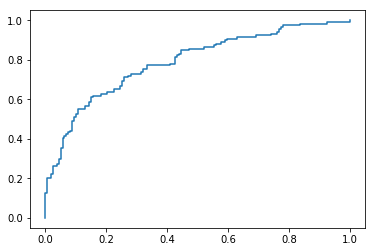

In [74]:
plt.plot(fpr, tpr)

In [34]:
y_true1_ = []
for y in y_true1:
    y_true1_ += y

In [36]:
y_true1_ = np.array(y_true1_)

In [28]:
res1_ = [torch.argmax(x, dim=1) for x in res1]

In [30]:
res1_ = torch.cat(res1_)

In [37]:
res1_ = res1_.numpy()

In [38]:
res1_[res1_>0] = 1

In [39]:
np.mean(res1_[y_true1_ > 0] == 1)

0.9090909090909091

In [18]:
get_FP_recall(y_true, res)

(0.8849557522123894,
 0.7857142857142857,
 0.5465116279069767,
 0.6946902654867256)

In [20]:
get_FP_recall(y_true1, res1)

/home/jxw/anaconda3/envs/tf2.0/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jxw/anaconda3/envs/tf2.0/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.9090909090909091, 0.6318181818181818, nan, 0.6318181818181818)

In [13]:
test_acc

0.9889600487953645

In [40]:
preds = [sigmiod_(pred.numpy()) for pred in res]

In [14]:
recall

0.6946902654867256

In [29]:
def sigmiod_(x):
    return -np.log(1/x-1)

In [41]:
preds = [torch.softmax(torch.from_numpy(pred), 1) for pred in preds]

In [43]:
preds = [pred.numpy() for pred in preds]

In [45]:
preds[0].shape

(73, 2)

In [23]:
len(test_res[names[0]]['bbox_pred'])

73

In [53]:
preds[0][:, 1] > 0.5

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False,  True, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [50]:
names[0]

'0274937'

In [46]:
test_res_new = {}
for i, name in enumerate(names):
    now = test_res[name]
    idx = preds[i][:, 1] >= 0.5
    now['bbox_pred'] = np.array(test_res[name]['bbox_pred'])[idx].tolist()
    now['score'] = np.array(test_res[name]['score'])[idx].tolist()
    test_res_new[name] = now

In [58]:
for name in names:
    if test_res_new[name]['bbox_pred'] ==[]:
        print(name)

0383210


In [61]:
a = np.array(test_res['0383210']['bbox_pred'])

In [62]:
a.ndim

1

In [64]:
test_res_new.pop('0383210')

{'bbox_gt': [[0.8412371134020619,
   0.501953125,
   0.52734375,
   0.11206313752461358,
   0.09577241645244217,
   0.09376904884318765]],
 'bbox_pred': [],
 'score': []}

100%|██████████| 186/186 [00:00<00:00, 1906.40it/s]


Text(0, 0.5, 'Sensitivity')

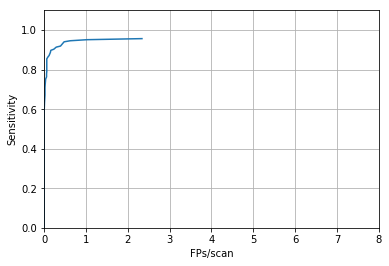

In [10]:
fps, tps, traintps = froc(test_res_new, 'iou', iou_threshold=0.3)
plt.plot(fps,tps)
plt.grid(True, which="both",ls="-") 
plt.xlim(0, 8)
plt.ylim(0, 1.1)
plt.xlabel('FPs/scan')
plt.ylabel('Sensitivity')
# plt.savefig('results/FP_reduction.png')

In [11]:
tps

array([0.95698925, 0.9516129 , 0.94623656, 0.94086022, 0.91935484,
       0.91397849, 0.90322581, 0.89784946, 0.88709677, 0.88709677,
       0.87096774, 0.87096774, 0.8655914 , 0.86021505, 0.85483871,
       0.83870968, 0.80107527, 0.79032258, 0.77956989, 0.76344086,
       0.75268817, 0.72580645, 0.70967742, 0.67204301, 0.6344086 ,
       0.57526882, 0.53225806, 0.48387097, 0.40860215, 0.33333333,
       0.2311828 , 0.1344086 , 0.06989247, 0.03763441, 0.03225806,
       0.01075269, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [12]:

for n in [0.125, 0.25, 0.5, 1, 2, 4, 8]:
    for i in range(len(fps)):
        if fps[i] >= n and fps[i+1] <= n:
            temp = (tps[i] - tps[i+1]) / (fps[i] - fps[i+1]) * (n - fps[i+1]) + tps[i+1]
            print(n, temp)
            break

0.125 0.8743279569892473
0.25 0.9066471163245357
0.5 0.9416567104739149
1 0.9512544802867384
2 0.9556010928961749


In [6]:
a = [[] for i in range(5)]
for name in test_res.keys():
    idx = int(sum(lesion_size[name][0]) / 3 // 10)
    if idx < 3:
        a[0].append(name)
    elif 3<=idx<5:
        a[1].append(name)
    elif 5<=idx<7:
        a[2].append(name)
    elif 7<=idx<10:
        a[3].append(name)
    else:
        a[4].append(name)

In [44]:
for b in a:
    print(len(b))
    res = {}
    for name in b:
        if name not in test_res_new: continue
        res[name] = test_res_new[name]
        fps, tps, traintps = froc(res, 'iou', iou_threshold=0.3)
        sen = []
    for n in [0.125, 0.25, 0.5, 1, 2, 4, 8]:
        for i in range(len(fps)):
            if fps[i] >= n and fps[i+1] <= n:
                temp = (tps[i] - tps[i+1]) / (fps[i] - fps[i+1]) * (n - fps[i+1]) + tps[i+1]
                print(n, temp)
                sen.append(temp)
                break
    print(np.mean(sen))

  0%|          | 0/15 [00:00<?, ?it/s]

25


100%|██████████| 15/15 [00:00<00:00, 717.13it/s]


0.125 0.8
0.25 0.8
0.5 0.84
1 0.8844444444444445
0.8311111111111111
61


  0%|          | 0/15 [00:00<?, ?it/s]

0.125 0.9333333333333333
0.25 0.9333333333333333
0.5 0.95
1 0.95
0.9416666666666667
53


  0%|          | 0/19 [00:00<?, ?it/s]

0.125 0.8985849056603774
0.25 0.9141509433962265
0.5 0.9433962264150944
1 0.9433962264150944
2 0.9433962264150944
0.9285849056603774
28


100%|██████████| 20/20 [00:00<00:00, 2200.46it/s]

0.125 1.0
0.25 1.0
0.5 1.0
1 1.0
2 1.0
1.0
20
0.125 0.25
0.25 0.5
0.5 0.8
1 0.9249999999999999
2 1.0
4 1.0
0.7458333333333332


In [10]:
for name in a[1]:
    print(name, lesion_size[name])

0489094 [[37.718770078614305, 45.77748, 43.733340000000005]]
0337370 [[41.708473107384854, 29.44557, 38.367419999999996]]
0271298 [[44.91522, 48.075720000000004, 39.22485]]
0448657 [[31.31691635096425, 37.70445, 32.68146]]
0283441 [[54.60000000000001, 34.483470000000004, 54.14976]]
0365751 [[37.828367993598135, 42.36183, 42.75831]]
0274306 [[36.183209999999995, 27.007679999999997, 38.40795000000001]]
0287514 [[63.804300000000005, 39.08667, 44.17182]]
0364881 [[40.99623018052074, 38.2305, 48.88023]]
0393979 [[38.392876738560375, 41.21838, 36.399930000000005]]
0498180 [[42.3174050833045, 27.16728, 36.110969999999995]]
0416700 [[55.74179759863976, 40.94013, 46.467540000000014]]
0350104 [[50.8474182241308, 31.68522, 41.30133]]
0447107 [[54.64098221509735, 46.61412, 47.12273999999999]]
0335980 [[39.24644846338595, 30.39582, 20.436465]]
0321859 [[42.34635865376913, 31.31415, 34.925520000000006]]
0362227 [[42.93369143021308, 31.27362, 33.190290000000005]]
0284239 [[54.97485, 31.10751000000000

In [42]:
def sigmiod(x):
    return 1 / (1 + np.exp(-x))

In [37]:
recall

0.990909090909091

In [41]:
num_postive

220.0

In [21]:
a = [1, 4, 2,5]
b = a.copy()

In [22]:
a[0] = 3

In [23]:
np.random.shuffle(a)

In [25]:
b

[1, 4, 2, 5]

In [103]:
labels = []
preds = []
res = {}
model.model.eval()
with torch.no_grad():
    for name in tqdm(datagenerator.train_list):
        t = {}
        labels = []
        preds = []
        bbox, label = datagenerator.get_all_bbox(name, True, False)
        for i in range(0, len(label), 16):
            ims = torch.tensor(bbox[i:i+16], dtype=torch.float32).cuda()
            pred, _ = model.model(ims)
            pred = pred.cpu().detach()
#             pred = torch.softmax(pred, dim=0).cpu().detach()
            preds.append(pred)
        preds = torch.cat(tuple(preds), dim=0).numpy()
        labels += label
        t['label'] = labels
        t['pred'] = preds
        res[name] = t

100%|██████████| 187/187 [25:51<00:00,  8.71s/it]


In [105]:
with open('./results/test_single_torch.json', 'r') as f:
    test_res1 = json.load(f)

In [9]:
with open('./results/test_single_torch_fp.json', 'r') as f:
    test_res_new = json.load(f)

In [4]:
with open('./results/lesion_size.json', 'r') as f:
    lesion_size = json.load(f)

In [127]:
with open('./results/fold0_test_fp.json', 'w') as f:
    json.dump(test_res3, f)

In [106]:
for name in res.keys():
    test_res1[name]['cls'] = np.argmax(res[name]['pred'], axis=1).tolist()

In [107]:
def get_new_res(test_res):
    test_res2 = {}
    for i, name in enumerate(test_res.keys()):
    #     if i < 13:
    #         continue
        temp = {}
        bbox = np.array(test_res[name]['bbox_pred'])
        score = np.array(test_res[name]['score'])
        cls = np.array(test_res[name]['cls'])
        idx = cls > 0
        if np.sum(idx) < 1:
            idx = np.array([0])
        temp['bbox_pred'] = bbox[idx].tolist()
        temp['score'] = score[idx].tolist()
        temp['bbox_gt'] = test_res[name]['bbox_gt']
        test_res2[name] = temp
    return test_res2
#     print(bbox.shape, score.shape, cls.shape)
#     break

In [108]:
test_res3 = get_new_res(test_res1)

In [111]:
test_res3.update(test_res2)

In [121]:
fps, tps, tr = froc(test_res3, 'iou', mesh=np.arange(0.01, 0.6, 0.001))

100%|██████████| 200/200 [00:01<00:00, 179.26it/s]


In [123]:
fps = np.insert(fps,0, 10)
tps = np.insert(tps,0, np.max(tps))

In [124]:
fps

array([1.000e+01, 1.835e+00, 1.685e+00, 1.595e+00, 1.480e+00, 1.410e+00,
       1.335e+00, 1.265e+00, 1.220e+00, 1.125e+00, 1.085e+00, 1.030e+00,
       9.100e-01, 8.750e-01, 7.950e-01, 7.400e-01, 7.300e-01, 6.950e-01,
       6.750e-01, 6.400e-01, 6.150e-01, 6.000e-01, 5.750e-01, 5.400e-01,
       5.150e-01, 5.100e-01, 4.850e-01, 4.800e-01, 4.700e-01, 4.550e-01,
       4.500e-01, 4.350e-01, 4.200e-01, 4.000e-01, 4.000e-01, 3.850e-01,
       3.800e-01, 3.700e-01, 3.600e-01, 3.500e-01, 3.400e-01, 3.400e-01,
       3.350e-01, 3.300e-01, 3.250e-01, 3.250e-01, 3.000e-01, 2.900e-01,
       2.850e-01, 2.600e-01, 2.550e-01, 2.550e-01, 2.500e-01, 2.500e-01,
       2.500e-01, 2.450e-01, 2.400e-01, 2.400e-01, 2.300e-01, 2.250e-01,
       2.150e-01, 2.150e-01, 2.050e-01, 2.000e-01, 1.900e-01, 1.800e-01,
       1.700e-01, 1.700e-01, 1.700e-01, 1.600e-01, 1.600e-01, 1.600e-01,
       1.600e-01, 1.600e-01, 1.600e-01, 1.600e-01, 1.600e-01, 1.550e-01,
       1.550e-01, 1.500e-01, 1.500e-01, 1.500e-01, 

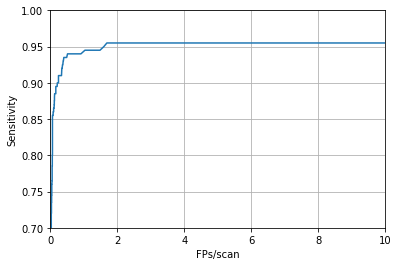

In [126]:
plt.plot(fps, tps)
plt.grid(True, which="both",ls="-") 
plt.xlim(0, 10)
plt.ylim(0.7, 1)
plt.xlabel('FPs/scan')
plt.ylabel('Sensitivity')
plt.savefig('fold0_test_fp.jpg')

In [14]:
res1 = res

In [15]:
labels = []
preds = []
res = {}
model.model.eval()
with torch.no_grad():
    for name in tqdm(datagenerator.train_list):
        t = {}
        labels = []
        preds = []
        bbox, label = datagenerator.get_all_bbox(name, True, False)
        for i in range(0, len(label), 16):
            ims = torch.tensor(bbox[i:i+16], dtype=torch.float32).cuda()
            pred = model.model(ims).cpu().detach()
#             pred = torch.softmax(pred, dim=0).cpu().detach()
            preds.append(pred)
        preds = torch.cat(tuple(preds), dim=0).numpy()
        labels += label
        t['label'] = labels
        t['pred'] = preds
        res[name] = t

100%|██████████| 187/187 [11:50<00:00,  4.12s/it]


In [16]:
res

{'0456073': {'label': [1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  'pred': array([[-8.007953  ,  3.6368465 , -0.987057  ],
         [-2.2533    ,  1.0842693 , -1.5139507 ],
         [ 3.3138354 , -1.8002194 , -2.8421433 ],
         [10.853862  , -4.5099964 , -8.396045  ],
         [ 5.4464307 , -1.6477982 , -5.204943  ],
         [ 7.876732  , -4.1474156 , -4.798078  ],
         [ 9.59974   , -6.2605805 , -5.1940956 ],
         [ 2.4230068 , -0.16865265, -4.196654  ],
         [12.786015  , -6.540589  , -7.7897024 ],
         [ 9.423223  , -4.836461  , -6.1122227 ],
         [ 9.429345  , -5.302342  , -5.700627  ],
         [ 8.774938  , -3.77040

In [76]:
def roc_cur(preds, labels, preds_, y_true_):
    preds = torch.cat(tuple(preds), dim=0)
#     preds = torch.cat((preds, preds_[-1500:-409]), dim=0)
    preds = torch.softmax(preds, dim=1).numpy()
    pred_label = np.argmax(preds, axis=1)
    labels = np.array(labels)
    preds[:, 1] += preds[:, 2]
    y_true = np.array(labels > 0, dtype=np.int32)
#     y_true = np.append(y_true, y_true_[-1500:-409])
    fpr, tpr, th = roc_curve(y_true, np.maximum(preds[:, 1], 0))
    return fpr, tpr, pred_label

In [71]:
len(preds)

34

In [39]:
len(labels)

409

In [41]:
preds_[-2000:-409]

torch.Size([21545, 3])

In [7]:
preds_ = torch.cat(tuple(preds), dim=0)

In [12]:
preds = torch.softmax(preds_, dim=1)

In [14]:
preds = preds.numpy()

In [17]:
labels = np.array(labels)

In [18]:
preds[:, 1] += preds[:, 2]

In [22]:
y_true = np.array(labels > 0, dtype=np.int32)

In [20]:
from sklearn.metrics import roc_curve, auc

In [78]:
fpr, tpr, pred_label = roc_cur(preds, labels, preds_, y_true)

In [79]:
pred_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [81]:
labels = np.array(labels)

In [82]:
labels

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,

In [83]:
pred1 = np.array(pred_label > 0, np.int32)
label1 = np.array(labels > 0, np.int32)

In [84]:
TP = np.sum(label1[pred1 == 1])
FN = np.sum(label1) - TP
FP = np.sum(pred1[label1==0])
TN = np.sum(label1==0) - FP

In [87]:
print(TP, FN, FP, TN)

16 4 6 383


In [88]:
TP / (TP + FN)

0.8

In [74]:
auc(fpr, tpr)

0.9582262210796916

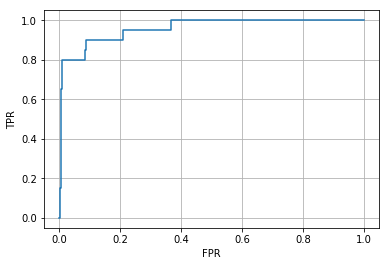

In [75]:
plt.plot(fpr, tpr)
plt.grid(True, which="both",ls="-") 
# plt.xlim(0, 1.0)
# plt.ylim(0, 1.1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.savefig('./results/roc.jpg')

In [37]:
tpr

array([0.  , 0.  , 0.15, 0.15, 0.65, 0.65, 0.75, 0.75, 0.8 , 0.8 , 0.85,
       0.85, 0.9 , 0.9 , 0.95, 0.95, 1.  , 1.  ])

In [38]:
fpr

array([0.        , 0.00257069, 0.00257069, 0.00514139, 0.00514139,
       0.00771208, 0.00771208, 0.01028278, 0.01028278, 0.0848329 ,
       0.0848329 , 0.0874036 , 0.0874036 , 0.21079692, 0.21079692,
       0.36760925, 0.36760925, 1.        ])

In [49]:
torch.softmax(pred, dim=1)

tensor([[0.2981, 0.3454, 0.3565],
        [0.2913, 0.3812, 0.3276],
        [0.3206, 0.3002, 0.3792],
        [0.2585, 0.4484, 0.2931],
        [0.4175, 0.2914, 0.2911],
        [0.4446, 0.2646, 0.2908],
        [0.3131, 0.3062, 0.3807]])

In [112]:
torch.argmax(pred, dim=1)

tensor([1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')

In [20]:
torch.eq(a, torch.tensor(label, dtype=torch.long).cuda()).sum().item()

15

In [21]:
label.shape[0]

AttributeError: 'list' object has no attribute 'shape'

In [136]:
res = {}
for i in range(5):
    with open('./results/fold{}.json'.format(i), 'r') as f:
        fold = json.load(f)
        res.update(fold)

In [137]:
len(res.keys())

936

In [138]:
with open('./results/5_fold.json', 'w') as f:
    json.dump(res, f)